## Data preparation

### Data description

In this study use the historical data for the period from 2015 to Apr 2021 that downloaded from Yahoo finance website to predict stock price of six famous technology:
- Apple
- Amazon
- Google
- Meta (Facebook)
- Microsoft 
- Tesla

### Dependencies loading

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Data loading

In this project, we only use close prices for studying. So let load only close price of 6 stocks into 1 dataframe

In [7]:
# Note: this code is copied from chatGPT

# Specify the directory containing the CSV files for each stock
directory = '../Data/Raw data'

# Initialize an empty list to store DataFrames for each stock
dfs = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Read the CSV file into a DataFrame
        file_path = os.path.join(directory, filename)
        stock_symbol = os.path.splitext(filename)[0]  # Extract the stock symbol from the filename
        df = pd.read_csv(file_path, parse_dates=['Date'])  # Assuming 'Date' is the column with timestamps
        df.rename(columns={'Close': stock_symbol}, inplace=True)  # Rename 'Close' column to stock symbol
        df.set_index('Date', inplace=True)  # Set the 'Date' column as index
        dfs.append(df[[stock_symbol]])  # Append only the 'Close' column to the list

# Merge all DataFrames based on their timestamps
df = pd.concat(dfs, axis=1)

# Print the merged DataFrame
df.head()

,AAPL,AMZN,GOOG,META,MSFT,TSLA
Date,,,,,,
2015-01-02,27.332500,15.4260,26.168653,78.449997,46.759998,14.620667
2015-01-05,26.562500,15.1095,25.623152,77.190002,46.330002,14.006000
2015-01-06,26.565001,14.7645,25.029282,76.150002,45.650002,14.085333
2015-01-07,26.937500,14.9210,24.986401,76.150002,46.230000,14.063333
2015-01-08,27.972500,15.0230,25.065184,78.180000,47.590000,14.041333


At the time the data was downloaded, the stock split has taken place while when the paper was published, it still used the pre-split stock data. The adjustment was done by multiplying prices of Google, Amazon and Tesla by 20, 20 and 3, respectively.

In [8]:
df['Pre-Split GOOG'] = df['GOOG'] * 20
df['Pre-Split AMZN'] = df['AMZN'] * 20
df['Pre-Split TSLA'] = df['TSLA'] * 3


df.drop(columns=['GOOG'], inplace=True)
df.drop(columns=['AMZN'], inplace=True)
df.drop(columns=['TSLA'], inplace=True)

df.rename(columns={'Pre-Split GOOG': 'GOOG'}, inplace=True)
df.rename(columns={'Pre-Split AMZN': 'AMZN'}, inplace=True)
df.rename(columns={'Pre-Split TSLA': 'TSLA'}, inplace=True)
df.head()

,AAPL,META,MSFT,GOOG,AMZN,TSLA
Date,,,,,,
2015-01-02,27.332500,78.449997,46.759998,523.37306,308.52,43.862001
2015-01-05,26.562500,77.190002,46.330002,512.46304,302.19,42.018000
2015-01-06,26.565001,76.150002,45.650002,500.58564,295.29,42.255999
2015-01-07,26.937500,76.150002,46.230000,499.72802,298.42,42.189999
2015-01-08,27.972500,78.180000,47.590000,501.30368,300.46,42.123999


### Checking the missing value

In [9]:
df.isna().sum()

AAPL    0
META    0
MSFT    0
GOOG    0
AMZN    0
TSLA    0
dtype: int64

There is no missing value

### Summary statistics

In [10]:
df.describe()

,AAPL,META,MSFT,GOOG,AMZN,TSLA
count,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000
mean,52.243806,164.503832,106.837349,1062.080319,1470.665085,126.360633
std,30.286772,56.620325,59.030853,380.132881,871.272062,180.855495
min,22.584999,74.050003,40.290001,491.201400,286.950000,28.734000
25%,30.317501,118.885002,56.580002,761.935030,745.787510,45.925499
50%,42.603750,165.750000,92.354999,1045.270010,1445.089950,58.959000
75%,56.753749,191.764996,138.932495,1227.634985,1883.502470,71.402502
max,143.160004,329.510010,261.970001,2429.889980,3531.449900,883.090026


### Time series visualization

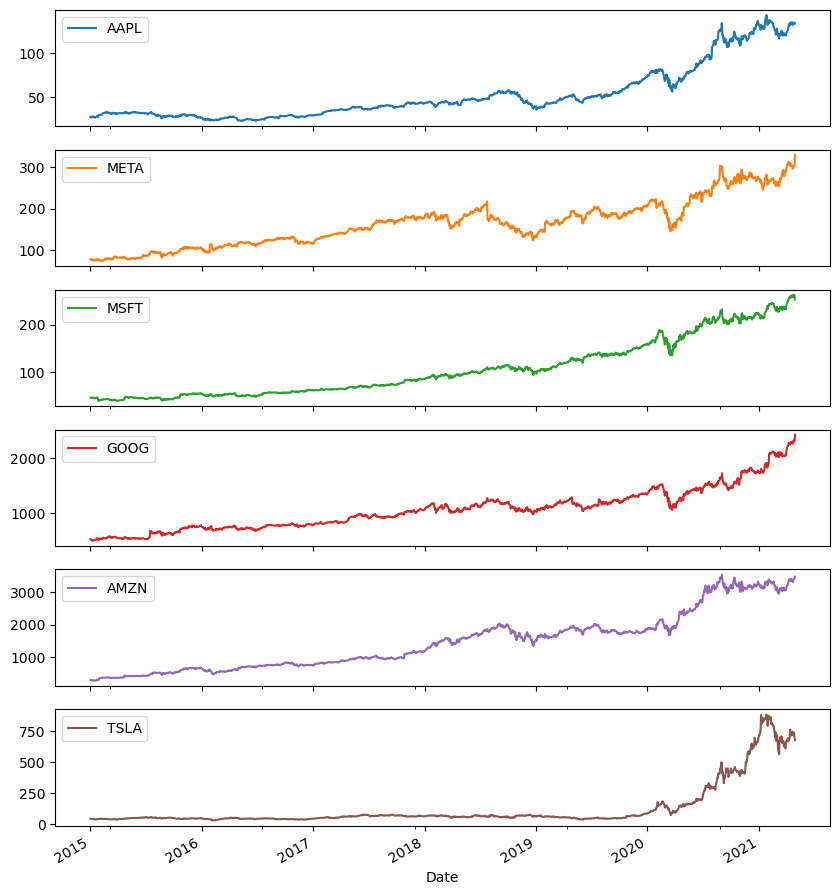

In [11]:
df.plot(subplots=True, figsize=(10,12));

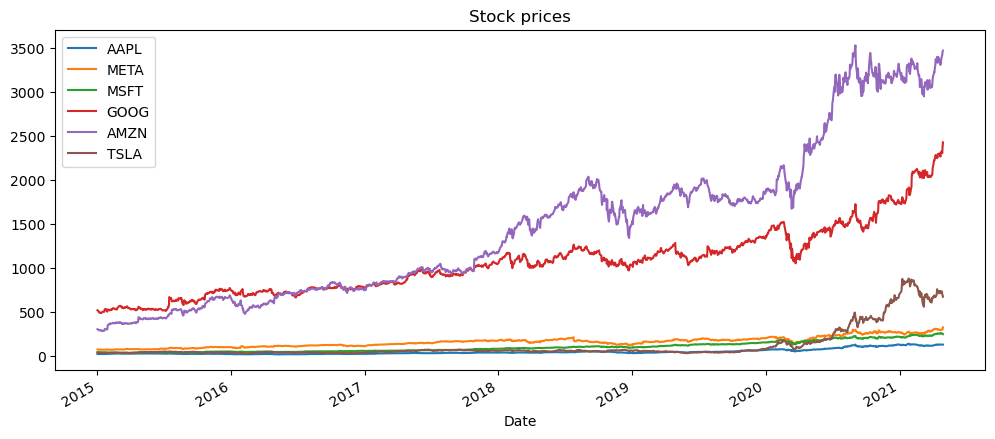

In [12]:
df.plot(subplots=False, figsize=(12,5));
plt.title("Stock prices");

### Split data into train and test dataset

To train the forecasting models, the price of each stock before January 2020 is used and the model's prediction ability is tested using data from January 2020 to April 2021

In [13]:
train_date = '2019-12-31' # data from 2015 to 2019
test_date = '2020-01-01' # data after 2020

df_train = df.loc[:train_date]
df_test = df.loc[test_date:]

In [14]:
df_train.shape

(1258, 6)

In [15]:
df_test.shape

(334, 6)

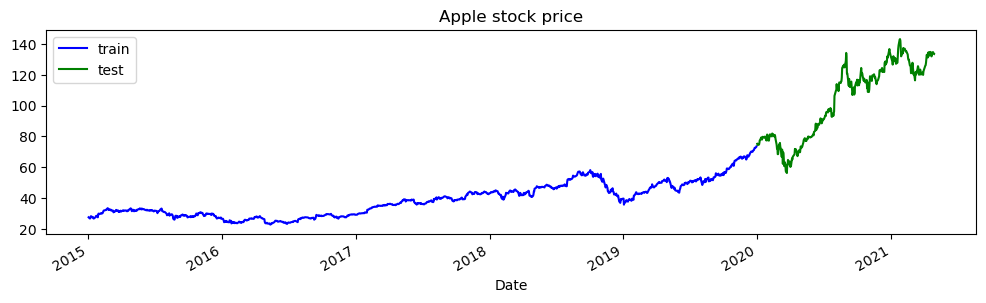

In [16]:
fig,ax=plt.subplots(figsize=(12,3))
df_train['AAPL'].plot(ax=ax, style='b', legend=True, label='train')
df_test['AAPL'].plot(ax=ax, style='g', legend=True, label='test')
plt.title('Apple stock price');

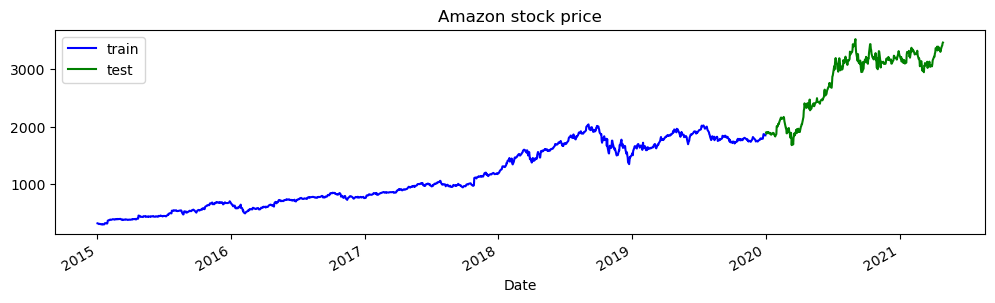

In [17]:
fig,ax=plt.subplots(figsize=(12,3))
df_train['AMZN'].plot(ax=ax, style='b', legend=True, label='train')
df_test['AMZN'].plot(ax=ax, style='g', legend=True, label='test')
plt.title('Amazon stock price');

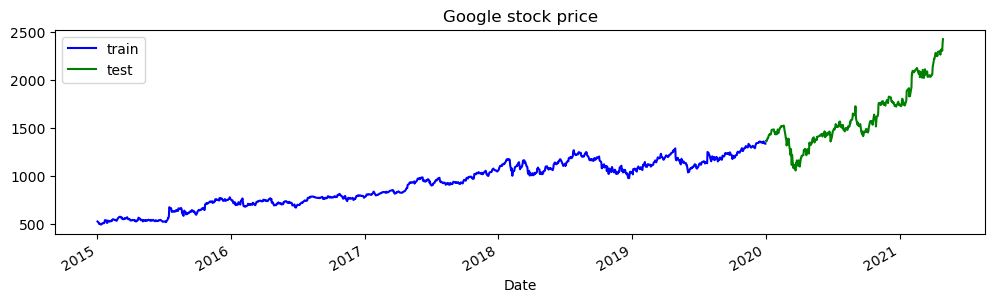

In [18]:
fig,ax=plt.subplots(figsize=(12,3))
df_train['GOOG'].plot(ax=ax, style='b', legend=True, label='train')
df_test['GOOG'].plot(ax=ax, style='g', legend=True, label='test')
plt.title('Google stock price');

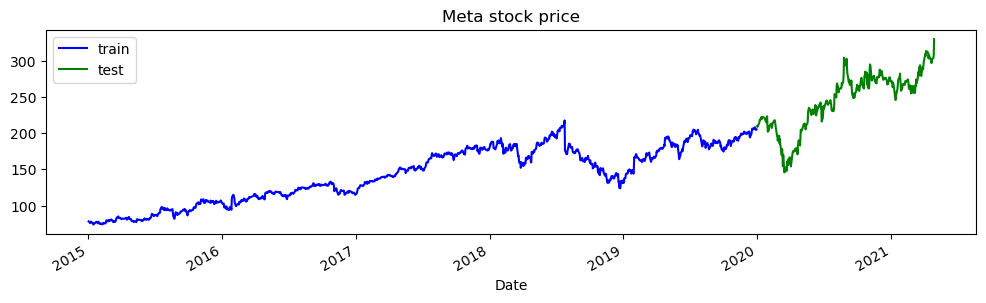

In [19]:
fig,ax=plt.subplots(figsize=(12,3))
df_train['META'].plot(ax=ax, style='b', legend=True, label='train')
df_test['META'].plot(ax=ax, style='g', legend=True, label='test')
plt.title('Meta stock price');

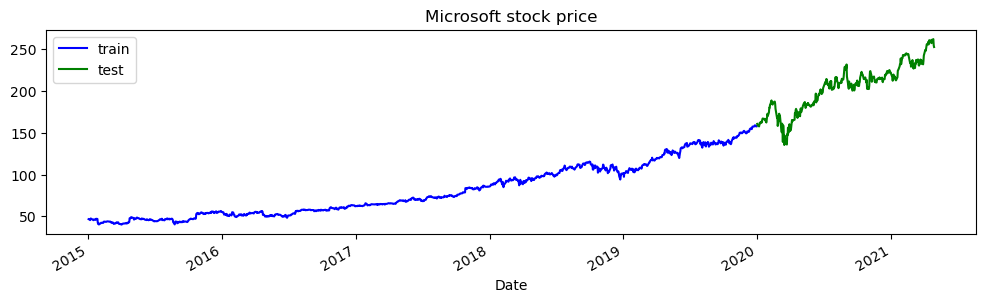

In [20]:
fig,ax=plt.subplots(figsize=(12,3))
df_train['MSFT'].plot(ax=ax, style='b', legend=True, label='train')
df_test['MSFT'].plot(ax=ax, style='g', legend=True, label='test')
plt.title('Microsoft stock price');

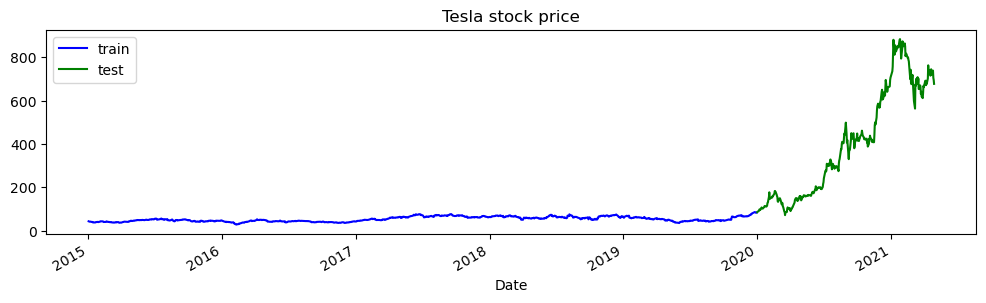

In [21]:
fig,ax=plt.subplots(figsize=(12,3))
df_train['TSLA'].plot(ax=ax, style='b', legend=True, label='train')
df_test['TSLA'].plot(ax=ax, style='g', legend=True, label='test')
plt.title('Tesla stock price');

Save the train and test dataset to csv files for model building

In [22]:
df_train.to_csv("../Data/Data train-test/train.csv")
df_test.to_csv("../Data/Data train-test/test.csv")